In [59]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from helpers.utils import *
from sklearn.metrics import accuracy_score
# %matplotlib ipympl


device = 'cuda' if torch.cuda.is_available() else "cpu"

In [2]:
training_data = datasets.FashionMNIST(
    root='datasets',
    train=True,                 # Which subset
    download=True,
    transform=ToTensor(),       # Transform the data
    target_transform=None       # Transform the targets/labels
)

testing_data = datasets.FashionMNIST(
    root='datasets',
    train=False,                # Which subset
    download=True,
    transform=ToTensor(),       # Transform the data
    target_transform=None       # Transform the targets/labels
)

In [3]:
len(training_data), len(testing_data)

(60000, 10000)

In [4]:
image, label = training_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [58]:
class_names = training_data.classes
num_classes = len(class_names)
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

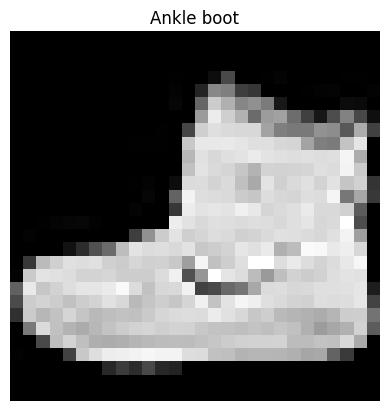

In [6]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis("off")
plt.show()

In [8]:
len(training_data)

60000

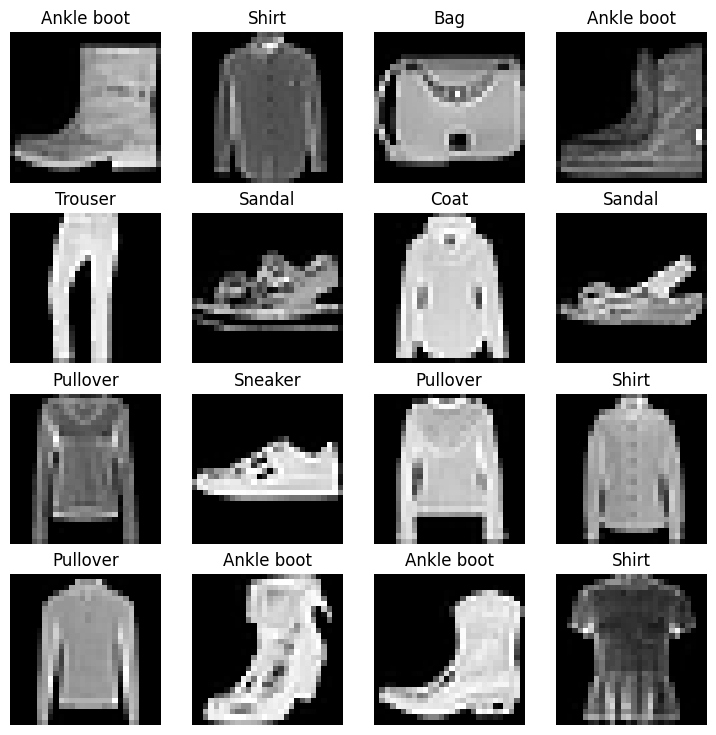

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(training_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    plt.imshow(training_data[random_idx][0].squeeze(), cmap="gray")
    plt.title(class_names[training_data[random_idx][1]])
    plt.axis("off")
    

In [52]:
batch_size = 32

train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=2,
)

test_dataloader = DataLoader(
    testing_data,
    batch_size=batch_size,
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f1e368d49d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1ddbe173d0>)

In [53]:
len(train_dataloader)

1875

In [54]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

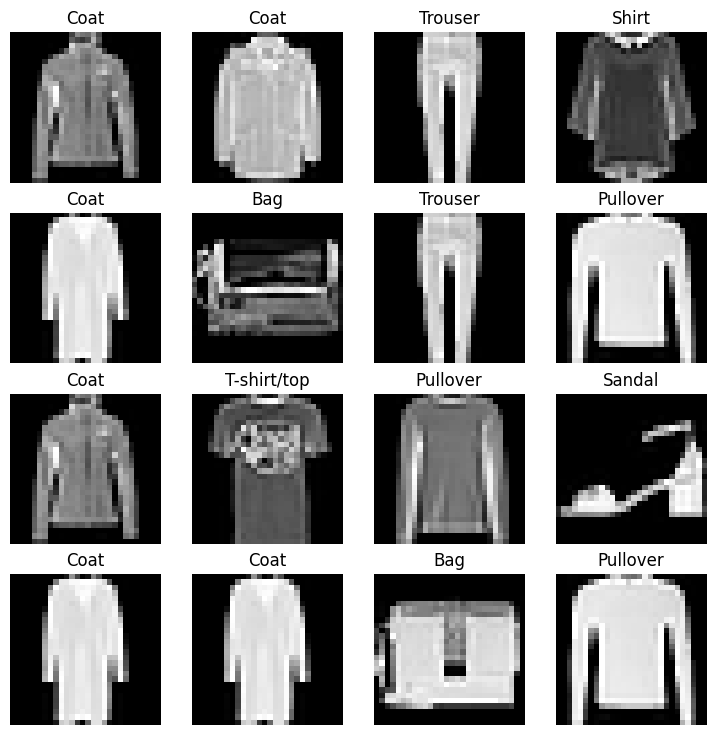

In [55]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    plt.subplot(rows, cols, i)
    plt.imshow(train_features_batch[random_idx].squeeze(), cmap="gray")
    plt.title(class_names[train_labels_batch[random_idx]])
    plt.axis("off")

In [26]:
class CnnModel(nn.Module):
    def __init__(self, num_in_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_in_channels = num_in_channels
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(self.num_in_channels, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_classes)
        )
        
    
    def forward(self, x):
        x = self.feature_extractor(x)
        return self.classifier(x)

In [91]:
model = CnnModel(1, 10).to(device)
summary(model, input_size=(1, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           9,248
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
          Flatten-14                   

In [92]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [107]:
from tqdm import tqdm

def train_epoch(model: nn.Module, train_ds: DataLoader):
    accs = []
    losses = []
    
    
    for inputs, targets in tqdm(train_ds, ncols=80, total=len(train_ds)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_onehot = nn.functional.one_hot(targets, num_classes).type(torch.float32)
        
        model.train()
        preds = model(inputs)
        loss = loss_fn(preds, targets_onehot)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        accs.append(accuracy_score(torch.argmax(preds, dim=-1).cpu().numpy(), targets.cpu().numpy(),))
        losses.append(loss.detach().cpu().numpy())
        
    return np.mean(losses), np.mean(accs)


def validation_epoch(model: nn.Module, val_ds: DataLoader):
    accs = []
    losses = []
    
    model.eval()
    with torch.inference_mode():
        for inputs, targets in tqdm(val_ds, ncols=80, total=len(val_ds)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_onehot = nn.functional.one_hot(targets, num_classes=num_classes).type(torch.float32)
            
            preds = model(inputs)
            loss = loss_fn(preds, targets_onehot)
            
            accs.append(accuracy_score(torch.argmax(preds, dim=-1).cpu().numpy(), targets.cpu().numpy(),))
            losses.append(loss.detach().cpu().numpy())
        
    return np.mean(losses), np.mean(accs)



def train_model(
    model: nn.Module, 
    train_ds: DataLoader, val_ds: DataLoader,
    save_path: Path, num_epochs: int):
    
    losses = []
    accs = []
    
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:')
        
        train_loss, train_acc = train_epoch(model, train_ds)
        val_loss, val_acc = train_epoch(model, val_ds)
        
        print(f'loss: {train_loss:0.4f} | acc: {train_acc:0.4f} | val_loss: {val_loss:0.4f} | val_acc: {val_acc:0.4f}\n')
        
        if len(val_losses) == 0 or val_loss < np.min(val_losses):
            save_state(save_path, model, optim, epoch)
        
        
        losses.append(train_loss)
        accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    return {
        'loss': losses,
        'acc': accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
        

In [93]:
num_epochs = 50
save_dir = Path('models')
save_path = save_dir / 'simple_cnn_model_fashion_mnist.pth'


history = train_model(model, train_dataloader, test_dataloader, save_path, num_epochs)

Epoch 1/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 331.23it/s]


loss: 0.4952 | acc: 0.8231 | val_loss: 0.3634 | val_acc: 0.8697

State Saved.
Epoch 2/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 330.19it/s]


loss: 0.3062 | acc: 0.8896 | val_loss: 0.3089 | val_acc: 0.8903

State Saved.
Epoch 3/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 321.38it/s]


loss: 0.2682 | acc: 0.9020 | val_loss: 0.2801 | val_acc: 0.8985

State Saved.
Epoch 4/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 338.76it/s]


loss: 0.2433 | acc: 0.9113 | val_loss: 0.2585 | val_acc: 0.9073

State Saved.
Epoch 5/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 345.20it/s]


loss: 0.2292 | acc: 0.9170 | val_loss: 0.2401 | val_acc: 0.9145

State Saved.
Epoch 6/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 371.91it/s]


loss: 0.2136 | acc: 0.9227 | val_loss: 0.2284 | val_acc: 0.9179

State Saved.
Epoch 7/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 373.76it/s]


loss: 0.2041 | acc: 0.9247 | val_loss: 0.2118 | val_acc: 0.9244

State Saved.
Epoch 8/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 371.01it/s]


loss: 0.1942 | acc: 0.9290 | val_loss: 0.2023 | val_acc: 0.9271

State Saved.
Epoch 9/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 310.13it/s]


loss: 0.1834 | acc: 0.9327 | val_loss: 0.1927 | val_acc: 0.9319

State Saved.
Epoch 10/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 309.08it/s]


loss: 0.1752 | acc: 0.9361 | val_loss: 0.1826 | val_acc: 0.9340

State Saved.
Epoch 11/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 348.26it/s]


loss: 0.1671 | acc: 0.9379 | val_loss: 0.1720 | val_acc: 0.9373

State Saved.
Epoch 12/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 362.77it/s]


loss: 0.1615 | acc: 0.9407 | val_loss: 0.1611 | val_acc: 0.9430

State Saved.
Epoch 13/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 367.62it/s]


loss: 0.1542 | acc: 0.9431 | val_loss: 0.1558 | val_acc: 0.9455

State Saved.
Epoch 14/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 341.77it/s]


loss: 0.1492 | acc: 0.9447 | val_loss: 0.1486 | val_acc: 0.9454

State Saved.
Epoch 15/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 371.01it/s]


loss: 0.1418 | acc: 0.9472 | val_loss: 0.1428 | val_acc: 0.9500

State Saved.
Epoch 16/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 357.48it/s]


loss: 0.1378 | acc: 0.9485 | val_loss: 0.1348 | val_acc: 0.9532

State Saved.
Epoch 17/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 361.50it/s]


loss: 0.1317 | acc: 0.9516 | val_loss: 0.1308 | val_acc: 0.9523

State Saved.
Epoch 18/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 349.93it/s]


loss: 0.1285 | acc: 0.9523 | val_loss: 0.1283 | val_acc: 0.9537

State Saved.
Epoch 19/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 348.73it/s]


loss: 0.1226 | acc: 0.9544 | val_loss: 0.1166 | val_acc: 0.9609

State Saved.
Epoch 20/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 353.48it/s]


loss: 0.1198 | acc: 0.9558 | val_loss: 0.1132 | val_acc: 0.9610

State Saved.
Epoch 21/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 339.07it/s]


loss: 0.1151 | acc: 0.9575 | val_loss: 0.1099 | val_acc: 0.9601

State Saved.
Epoch 22/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 279.53it/s]


loss: 0.1117 | acc: 0.9575 | val_loss: 0.1038 | val_acc: 0.9634

State Saved.
Epoch 23/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 297.86it/s]


loss: 0.1067 | acc: 0.9600 | val_loss: 0.0991 | val_acc: 0.9675

State Saved.
Epoch 24/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 283.29it/s]


loss: 0.1032 | acc: 0.9608 | val_loss: 0.0962 | val_acc: 0.9659

State Saved.
Epoch 25/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 300.29it/s]


loss: 0.0995 | acc: 0.9633 | val_loss: 0.0944 | val_acc: 0.9675

State Saved.
Epoch 26/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 300.34it/s]


loss: 0.0967 | acc: 0.9639 | val_loss: 0.0906 | val_acc: 0.9691

State Saved.
Epoch 27/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 313.53it/s]


loss: 0.0933 | acc: 0.9651 | val_loss: 0.0823 | val_acc: 0.9721

State Saved.
Epoch 28/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.55it/s]


loss: 0.0918 | acc: 0.9647 | val_loss: 0.0823 | val_acc: 0.9721

Epoch 29/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 308.56it/s]


loss: 0.0890 | acc: 0.9666 | val_loss: 0.0776 | val_acc: 0.9732

State Saved.
Epoch 30/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 301.20it/s]


loss: 0.0875 | acc: 0.9676 | val_loss: 0.0742 | val_acc: 0.9744

State Saved.
Epoch 31/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 333.03it/s]


loss: 0.0821 | acc: 0.9699 | val_loss: 0.0727 | val_acc: 0.9747

State Saved.
Epoch 32/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.62it/s]


loss: 0.0810 | acc: 0.9699 | val_loss: 0.0671 | val_acc: 0.9761

State Saved.
Epoch 33/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 317.97it/s]


loss: 0.0771 | acc: 0.9710 | val_loss: 0.0644 | val_acc: 0.9776

State Saved.
Epoch 34/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 312.65it/s]


loss: 0.0786 | acc: 0.9708 | val_loss: 0.0669 | val_acc: 0.9763

Epoch 35/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 306.10it/s]


loss: 0.0751 | acc: 0.9717 | val_loss: 0.0654 | val_acc: 0.9751

Epoch 36/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 300.59it/s]


loss: 0.0735 | acc: 0.9725 | val_loss: 0.0654 | val_acc: 0.9780

Epoch 37/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 319.92it/s]


loss: 0.0696 | acc: 0.9738 | val_loss: 0.0603 | val_acc: 0.9781

State Saved.
Epoch 38/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 380.64it/s]


loss: 0.0702 | acc: 0.9738 | val_loss: 0.0543 | val_acc: 0.9806

State Saved.
Epoch 39/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 303.99it/s]


loss: 0.0667 | acc: 0.9748 | val_loss: 0.0497 | val_acc: 0.9844

State Saved.
Epoch 40/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 296.59it/s]


loss: 0.0658 | acc: 0.9754 | val_loss: 0.0493 | val_acc: 0.9839

State Saved.
Epoch 41/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 313.79it/s]


loss: 0.0652 | acc: 0.9758 | val_loss: 0.0532 | val_acc: 0.9795

Epoch 42/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 312.34it/s]


loss: 0.0612 | acc: 0.9770 | val_loss: 0.0515 | val_acc: 0.9835

Epoch 43/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 307.92it/s]


loss: 0.0623 | acc: 0.9766 | val_loss: 0.0462 | val_acc: 0.9837

State Saved.
Epoch 44/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 310.25it/s]


loss: 0.0592 | acc: 0.9776 | val_loss: 0.0447 | val_acc: 0.9836

State Saved.
Epoch 45/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 302.50it/s]


loss: 0.0571 | acc: 0.9785 | val_loss: 0.0477 | val_acc: 0.9830

Epoch 46/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 304.11it/s]


loss: 0.0569 | acc: 0.9782 | val_loss: 0.0429 | val_acc: 0.9844

State Saved.
Epoch 47/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 310.82it/s]


loss: 0.0567 | acc: 0.9783 | val_loss: 0.0423 | val_acc: 0.9863

State Saved.
Epoch 48/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 305.89it/s]


loss: 0.0563 | acc: 0.9782 | val_loss: 0.0467 | val_acc: 0.9840

Epoch 49/50:


100%|████████████████████████████████████████| 313/313 [00:01<00:00, 288.64it/s]


loss: 0.0518 | acc: 0.9808 | val_loss: 0.0410 | val_acc: 0.9849

State Saved.
Epoch 50/50:


100%|████████████████████████████████████████| 313/313 [00:00<00:00, 313.56it/s]

loss: 0.0542 | acc: 0.9800 | val_loss: 0.0383 | val_acc: 0.9870

State Saved.


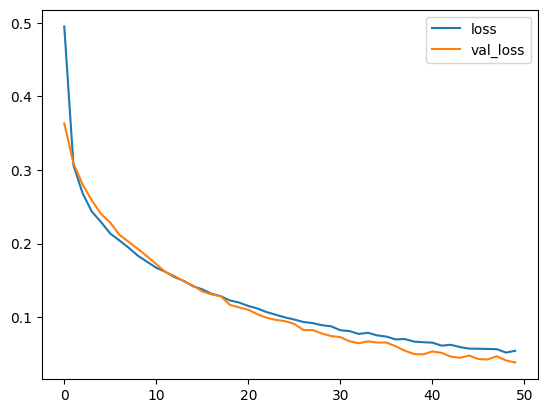

In [96]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])

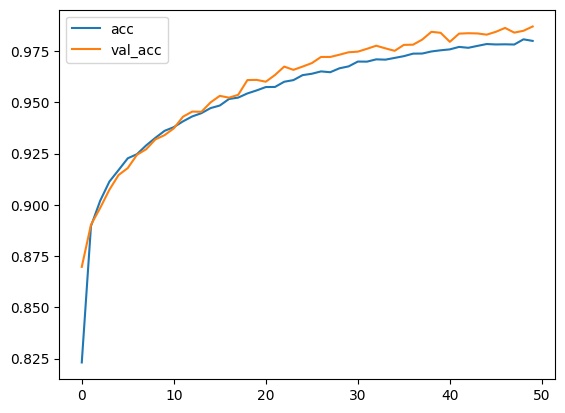

In [97]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [102]:
model1 = CnnModel(1, num_classes).to(device)
model1.load_state_dict(torch.load(save_path)['model_state'])

<All keys matched successfully>

In [108]:
validation_epoch(model1, test_dataloader)

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 622.23it/s]


(0.07854383, 0.9708466453674122)

In [109]:
validation_epoch(model, test_dataloader)

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 582.92it/s]


(0.07854383, 0.9708466453674122)